### MAC Season 4 Data Cleaning
#### Traits
- aboveground dry biomass
- days & growing degree days (GDD) to flowering
- days & GDD to flag leaf emergence
- canopy height (time series)

#### Update July 2020
##### The input data for the code in this notebook were downloaded from a Dryad data publication from the TERRA-REF project, lead author [David LeBauer](https://github.com/dlebauer). Information on the publication and access to data can be found in this [repository](https://github.com/terraref/data-publication). 


##### This notebook contains the code used to clean and curate sorghum data from Maricopa Agricultural Station Season Four. The input trait data were originally queried from betydb version 1 in April 2020 using this `R` code, but those data are no longer used in this notebook or for the updated derived datasets. 

```
library(traits)
library(dplyr)


options(betydb_url = "https://terraref.ncsa.illinois.edu/bety/",
        betydb_api_version = 'v1',
        betydb_key = 'abcde_super_secret_key_1234')

season_4 <- betydb_query(sitename  = "~Season 4",
                         limit     =  "none")

write.csv(season_4, file = 'mac_season_four_2020-04-22.csv')
```
- Environmental weather data were downloaded from the MAC weather station [website](https://cals.arizona.edu/azmet/06.htm). 
- Please email ejcain@arizona.edu with any questions or comments. 

### I. Import Python packages

In [34]:
import datetime
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import sqlalchemy 
# import sqlite3 

### II. Functions Used

In [53]:
def plot_hist(df, value_column, trait_column):
    
    """
    Return an exploratory histogram to visualize distribution of values of specific trait.
    """
    trait_name = df[trait_column].unique()[0]
    return df[value_column].hist(color='navy').set_xlabel(trait_name);

In [55]:
def check_for_nulls(df):
    
    """
    Takes dataframe as argument and returns table showing sum of null values, if any.
    """
    
    return df.isnull().sum()

In [57]:
def check_duplicates(df):
    
    """
    Takes dataframe as argument and returns value counts for duplicates, if any.
    """
    
    return df.duplicated().value_counts()

In [ ]:
def check_unique_values(df):
    
    """
    Function takes a dataframe as argument and checks for number of unique values in each column.
    Print statement will contain number of unique values, as well as the unique values for any column that
    contains less than 5 unique values.
    """
    for col in df.columns:
        
        if df[col].nunique() < 5:
            print(f'{df[col].nunique()} unique value(s) for {col} column: {df[col].unique()}')
            
        else:
            print(f'{df[col].nunique()} values for {col} column')

In [ ]:
def extract_range_column_values(working_df, plot_column):
    
    """
    To assist in plot location, function takes the working dataframe name, name of the plot column, and
    desired name of the new dataframe to be returned. Range and column values are extracted from the
    plot name strings and added as new columns to the returned dataframe. 
    """
    
    new_df = working_df.copy()

    new_df['range'] = new_df[plot_column].str.extract("Range (\d+)").astype(int)
    new_df['column'] = new_df[plot_column].str.extract("Column (\d+)").astype(int)
    
    return new_df

In [ ]:
def convert_datetime_column(working_df, date_column):
    
    """
    If date column does not contain datetime objects, function takes working dataframe and name of date column
    as arguments. The original date column is dropped, and a new dataframe with an updated datatime column
    is returned. 
    """
    
    new_datetimes = pd.to_datetime(working_df[date_column])
    
    new_df_0 = working_df.drop(labels=date_column, axis=1)
    new_df_1 = new_df_0.copy()
    new_df_1['date'] = new_datetimes
    
    return new_df_1

In [ ]:
def rename_value_column(working_df, value_column, trait_column):
    
    """
    Takes working dataframe, name of value column, and name of trait column as arguments. Returns a new dataframe
    with the name of the trait as the new name of the value column.
    """
    
    trait = working_df[trait_column].unique()[0]
    
    new_df_0 = working_df.rename({value_column: trait}, axis=1)
    new_df_1 = new_df_0.drop(labels=trait_column, axis=1)
    
    return new_df_1

In [ ]:
# may no longer need this function with new data
# def check_for_subplots(df):
    
#     """
#     Function takes a dataframe as argument and checks for sitename subplots ending in ' E' or ' W'
#     Will return rows with subplots, if any.
#     """
#     return df.loc[(df.sitename.str.endswith(' E')) | (df.sitename.str.endswith(' W'))]

### III. Read in datasets
- Season Four data can be downloaded from this Google [Drive](https://drive.google.com/open?id=1THk-NQYxkkej-zdQsqM7i9t-axyS0Sug)
- Each trait - separated by method, if applicable - can be found in its own `.csv` file
- Functions applied to all datasets
    - Plot distribution of values
    - Check for null values
    - Check for duplicates
    - Extract range and column values to add to dataframe
    - Convert string date column values to datetime objects
    - Rename values column (usually 'mean') to the trait being measured

#### A. Aboveground Dry Biomass

In [4]:
adb_0 = pd.read_csv('data/raw/season_4_traits/season_4_aboveground_dry_biomass_manual.csv')
print(adb_0.shape)
# adb_0.head()

(719, 12)


Text(0.5, 0, 'aboveground_dry_biomass')

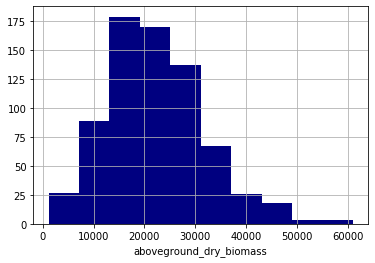

In [54]:
plot_hist(adb_0, 'mean', 'trait')

In [56]:
check_for_nulls(adb_0)

plot              0
scientificname    0
genotype          0
treatment         0
date              0
trait             0
method            0
mean              0
checked           0
author            0
season            0
method_type       0
dtype: int64

In [58]:
check_duplicates(adb_0)

False    719
dtype: int64

In [ ]:
check_unique_values(adb_0)

In [ ]:
adb_1 = extract_range_column_values(adb_0, 'plot')
print(adb_1.shape)
# adb_1.sample(n=3)

In [ ]:
# adb_1.dtypes

In [ ]:
adb_2 = convert_datetime_column(adb_1, 'date')
print(adb_2.shape)
# adb_2.head()

In [ ]:
# adb_2.dtypes

In [ ]:
adb_3 = rename_value_column(adb_2, 'mean', 'trait')
print(adb_3.shape)
# adb_3.tail()

### Original code to be refactored with more functions and different input data

In [ ]:
df_0 = pd.read_csv('data/raw/mac_season_four_2020-04-22.csv', low_memory=False)
print(df_0.shape)
# df_0.head(3)

#### III. Drop Columns

In [ ]:
# for col in df_0.columns:
#     if df_0[col].nunique() < 5:
#         print(f'Unique values for {col}: {df_0[col].unique()}')

In [ ]:
# df_0.columns

In [ ]:
cols_to_drop = ['Unnamed: 0', 'checked', 'result_type', 'id', 'citation_id', 'site_id', 'treatment_id', 'city', 
                'scientificname', 'commonname', 'genus', 'species_id', 'author', 'citation_year', 'time', 'raw_date', 
                'month', 'year', 'dateloc', 'n', 'statname', 'stat', 'notes', 'access_level', 'entity', 'view_url', 
                'edit_url']

In [ ]:
df_1 = df_0.drop(labels=cols_to_drop, axis=1)
print(df_1.shape)
# df_1.head(3)

#### IV. Change `date` format

In [ ]:
new_dates = []

for d in df_1.date.values:
    
    # strip '(America/Phoenix)' string from date
    if 'Phoenix' in d:
        new_name = d[:-18]
        new_dates.append(new_name)
    
    else:
        new_name = d
        new_dates.append(new_name)
        

# check that length of new dates matches number of rows
print(len(new_dates))
print(df_1.shape[0])

Convert string dates to datetime

In [ ]:
iso_format_dates = pd.to_datetime(new_dates)

Add new column with datetime values

In [ ]:
# copy df to avoid SettingWithCopyWarning
df_2 = df_1.copy()
df_2['date_1'] = iso_format_dates

print(df_2.shape)
# df_2.head(3)

#### V. Extract Range & Column Values for Location

In [ ]:
df_3 = df_2.copy()

df_3['range'] = df_3['sitename'].str.extract("Range (\d+)").astype(int)
df_3['column'] = df_3['sitename'].str.extract("Column (\d+)").astype(int)

# df_3.sample(n=3)

#### VI. Drop, Rename, & Reorder Columns

In [ ]:
# drop string date column and redundant trait columns

df_4 = df_3.drop(labels=['date'], axis=1)

In [ ]:
df_5 = df_4.rename({'date_1': 'date', 'mean': 'value'}, axis=1)

In [ ]:
new_col_order = ['sitename', 'range', 'column', 'lat', 'lon', 'date', 'treatment', 'trait', 'trait_description', 'method_name', 'cultivar', 'value', 'units']

df_6 = pd.DataFrame(data=df_5, columns=new_col_order).reset_index(drop=True)
print(df_6.shape)
# df_6.head(3)

#### VI. Select for specific traits
- aboveground dry biomass
- days & GDD to flowering
- days & GDD to flag leaf emergence
- canopy height - time series

#### A. Aboveground Dry Biomass

In [ ]:
adb_0 = df_6.loc[df_6.trait == 'aboveground_dry_biomass']
print(adb_0.shape)
adb_0.tail(3)

##### Check for E and W subplots

In [ ]:
# will have no output if there are no subplots

check_for_subplots(adb_0)

#### Drop & Rename Columns, Set Date as Index

In [ ]:
cols_to_drop = ['trait', 'trait_description', 'method_name']

adb_1 = adb_0.drop(labels=cols_to_drop, axis=1)
print(adb_1.shape)
# adb_1.head()

In [ ]:
adb_2 = adb_1.rename({'value': 'aboveground_dry_biomass'}, axis=1)
# adb_2.tail(3)

In [ ]:
adb_3 = adb_2.set_index(keys='date')
print(adb_3.shape)
# adb_3.head()

In [ ]:
adb_4 = adb_3.sort_index()
adb_4.head(3)

#### Write aboveground dry biomass dataframe to csv file with timestamp

In [ ]:
timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()
output_filename = f'data/processed/aboveground_dry_biomass_mac_season_4_{timestamp}.csv'.replace(':', '')

adb_4.to_csv(output_filename, index=True)

#### B. Days & Growing Degree Days (GDD) to Flowering

In [ ]:
flower_df_0 = df_6.loc[df_6.trait == 'flowering_time']
print(flower_df_0.shape)
flower_df_0.head(3)

##### Check for E and W subplots

In [ ]:
# will have no output if there are no subplots

check_for_subplots(flower_df_0)

#### Read in Season Four Weather Data from MAC Weather Station

In [ ]:
weather_df_0 = pd.read_csv('data/raw/mac_weather_station_raw_daily_2017.csv')
print(weather_df_0.shape)
weather_df_0.head(3)

#### Slice dataframe for season dates only and add date column
* Planting Date: 2017-04-20, Day 110
* Last Day of Harvest: 2017-09-16, Day 259

In [ ]:
weather_df_1 = weather_df_0.loc[(weather_df_0.day_of_year >= 110) & (weather_df_0.day_of_year <= 259)]
print(weather_df_1.shape)
weather_df_1.head(3)

In [ ]:
season_4_date_range = pd.date_range(start='2017-04-20', end='2017-09-16')

In [ ]:
weather_df_2 = weather_df_1.copy()
weather_df_2['date'] = season_4_date_range
print(weather_df_2.shape)
weather_df_2.tail(3)

#### Add Growing Degree Days
- 10 degrees Celsius is base temp for sorghum
- Daily gdd value = ((max temp + min temp) / 2) - 10 (base temp)
- Growing Degree Days = cumulative sum of daily gdd values
- Negative values convert to 0

In [ ]:
weather_df_3 = weather_df_2.copy()
weather_df_3['daily_gdd'] = (((weather_df_3['air_temp_max'] + weather_df_3['air_temp_min'])) / 2) - 10
print(weather_df_3.shape)
weather_df_3.head(3)

In [ ]:
# Check for negative values - will return empty df if there are none

weather_df_3.loc[weather_df_3.daily_gdd < 0]

In [ ]:
weather_df_4 = weather_df_3.copy()
weather_df_4['gdd'] = np.rint(np.cumsum(weather_df_4['daily_gdd']))
print(weather_df_4.shape)
weather_df_4.tail(3)

In [ ]:
# Drop daily gdd

weather_df_5 = weather_df_4.drop(labels='daily_gdd', axis=1)
print(weather_df_5.shape)
# weather_df_5.tail()

In [ ]:
weather_df_6 = weather_df_5.copy()
weather_df_6['cum_precip'] = np.round(np.cumsum(weather_df_6.precip_total), 2)
weather_df_6.head(3)

#### Add Irrigation Columns
- First water-deficit stress treatment: 2020-08-01 through 2020-08-14
- Second water-deficit stress treatment: 2020-08-15 through 2020-08-30

In [ ]:
# weather_df_6.dtypes

In [ ]:
first_treatment_dates = pd.date_range(start='2017-08-01', end='2017-08-14')
second_treatment_dates = pd.date_range(start='2017-08-15', end='2017-08-30')

In [ ]:
season_dates = weather_df_6.date.values

In [ ]:
first_treatment_dates

In [ ]:
# If a date falls within a treatment date range, it will have a value of True in the water deficit columns

first_treatment_col = []


for d in season_dates:
    
    if d in first_treatment_dates:
        
        first_treatment_col.append(True)
        
    else: 
        
        first_treatment_col.append(False)
        
print(len(first_treatment_col))

In [ ]:
second_treatment_col = []

for d in season_dates:
    
    if d in second_treatment_dates:
        
        second_treatment_col.append(True)
        
    else:
        
        second_treatment_col.append(False)

In [ ]:
weather_df_7 = weather_df_6.copy()

weather_df_7['first_water_deficit_treatment'] = first_treatment_col
weather_df_7['second_water_deficit_treatment'] = second_treatment_col

print(weather_df_7.shape)
weather_df_7.head(3)

#### Write weather data to csv

In [ ]:
timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()
output_filename = f'data/processed/mac_season_4_daily_weather_{timestamp}.csv'.replace(':', '')

weather_df_7.to_csv(output_filename, index=False)

#### Add planting date 2017-04-20

In [ ]:
day_of_planting = datetime.date(2017,4,20)
flower_df_1 = flower_df_0.copy()

flower_df_1['date_of_planting'] = day_of_planting
print(flower_df_1.shape)
# flower_df_1.head(3)

#### Create timedelta using days to flowering

In [ ]:
timedelta_values = flower_df_1['value'].values
dates_of_flowering = []

for val in timedelta_values:
    
    date_of_flowering = day_of_planting + datetime.timedelta(days=val)
    dates_of_flowering.append(date_of_flowering)
    
print(flower_df_1.shape[0])
print(len(dates_of_flowering))

In [ ]:
flower_df_2 = flower_df_1.copy()
flower_df_2['date_of_flowering'] = dates_of_flowering
print(flower_df_2.shape)
# flower_df_2.head(3)

#### Add GDD to flowering dataframe

In [ ]:
# slice df for date and cumulative gdd values only

season_4_gdd = weather_df_6[['date', 'gdd']]
print(season_4_gdd.shape)
season_4_gdd.head(3)

In [ ]:
# flower_df_2.dtypes

In [ ]:
flower_df_3 = flower_df_2.copy()
flower_df_3.date_of_flowering = pd.to_datetime(flower_df_3.date_of_flowering)
# flower_df_3.dtypes

In [ ]:
flower_df_4 = flower_df_3.merge(season_4_gdd, how='left', left_on='date_of_flowering', right_on='date')
print(flower_df_4.shape)
# flower_df_4.head(3)

#### Drop, Rename, and Sort Columns

In [ ]:
cols_to_drop = ['date_x', 'trait', 'method_name', 'units', 'date_of_planting', 'date_y']
flower_df_5 = flower_df_4.drop(labels=cols_to_drop, axis=1)
print(flower_df_5.shape)
# flower_df_5.tail(3)

In [ ]:
flower_df_6 = flower_df_5.rename({'value': 'days_to_flowering', 'gdd': 'gdd_to_flowering'}, axis=1)
print(flower_df_6.shape)
# flower_df_6.head()

#### Check for duplicates

In [ ]:
flower_df_6.duplicated().value_counts()

In [ ]:
duplicates = flower_df_6.loc[flower_df_6.duplicated() == True]
duplicates.iloc[0]

In [ ]:
# duplicates.loc[(duplicates.sitename == 'MAC Field Scanner Season 4 Range 46 Column 6') & (duplicates.cultivar == 'PI542718')]

#### Drop Duplicates

In [ ]:
flower_df_7 = flower_df_6.drop_duplicates(ignore_index=True)
print(flower_df_7.shape)
flower_df_7.tail(3)

In [ ]:
print(f'Number of non-duplicates in flower_df_6: {flower_df_6.loc[flower_df_6.duplicated() == False].shape[0]}')
print(f'Number of rows in dataframe after dropping duplicates: {flower_df_7.shape[0]}')

#### Write days to flowering dataframe to csv file with timestamp

In [ ]:
timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()
output_filename = f'data/processed/days_gdd_to_flowering_season_4_{timestamp}.csv'.replace(':', '')

flower_df_7.to_csv(output_filename, index=False)

#### C. Days & GDD to Flag Leaf Emergence

In [ ]:
fle_0 = df_6.loc[df_6.trait == 'flag_leaf_emergence_time']
print(fle_0.shape)
# fle_0.head(3)

##### Check for E and W subplots

In [ ]:
# will have no output if there are no subplots

check_for_subplots(fle_0)

#### Use sliced dataframe from days to flowering with date and gdd values only

In [ ]:
season_4_gdd.head(3)

#### Add planting date 2017-04-20

In [ ]:
day_of_planting = datetime.date(2017,4,20)
fle_1 = fle_0.copy()

fle_1['date_of_planting'] = day_of_planting
print(fle_1.shape)
# fle_1.head(3)

#### Create timedelta using days to flag leaf emergence

In [ ]:
timedelta_values = fle_1['value'].values
dates_of_flag_leaf_emergence = []

for val in timedelta_values:
    
    date_of_flag_leaf_emergence = day_of_planting + datetime.timedelta(days=val)
    dates_of_flag_leaf_emergence.append(date_of_flag_leaf_emergence)
    
print(fle_1.shape[0])
print(len(dates_of_flag_leaf_emergence))

In [ ]:
fle_2 = fle_1.copy()
fle_2['date_of_flag_leaf_emergence'] = dates_of_flag_leaf_emergence
print(fle_2.shape)
# fle_2.head(3)

#### Add GDD to flag leaf emergence

In [ ]:
# fle_2.dtypes

In [ ]:
fle_3 = fle_2.copy()
fle_3.date_of_flag_leaf_emergence = pd.to_datetime(fle_3.date_of_flag_leaf_emergence)
# fle_3.dtypes

In [ ]:
fle_4 = fle_3.merge(season_4_gdd, how='left', left_on='date_of_flag_leaf_emergence', right_on='date')
print(fle_4.shape)
# fle_4.head(3)

#### Drop & Rename Columns

In [ ]:
cols_to_drop = ['date_x', 'trait', 'method_name', 'units', 'date_of_planting', 'date_y']
fle_5 = fle_4.drop(labels=cols_to_drop, axis=1)
print(fle_5.shape)
# fle_5.tail(3)

In [ ]:
fle_6 = fle_5.rename({'value': 'days_to_flag_leaf_emergence', 'gdd': 'gdd_to_flag_leaf_emergence'}, axis=1)
print(fle_6.shape)
# fle_6.head()

#### Check for duplicates

In [ ]:
fle_6.duplicated().value_counts()

In [ ]:
# fle_6.loc[fle_6.duplicated() == True].iloc[0]

In [ ]:
# fle_6.loc[(fle_6.sitename == 'MAC Field Scanner Season 4 Range 16 Column 7') & (fle_6.cultivar == 'PI152651')]

#### Drop duplicates

In [ ]:
fle_7 = fle_6.drop_duplicates(ignore_index=True)
print(fle_7.shape)
fle_7.tail(3)

#### Write days to flag leaf emergence to csv file with timestamp

In [ ]:
timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()
output_filename = f'data/processed/days_gdd_to_flag_leaf_emergence_season_4_{timestamp}.csv'.replace(':', '')

fle_7.to_csv(output_filename, index=False)

### D. Canopy Height - Time Series

In [ ]:
ch_0 = df_6.loc[df_6.trait == 'canopy_height']
print(ch_0.shape)
# ch_0.head(3)

In [ ]:
subplots = check_for_subplots(ch_0)
subplots.shape

#### Take average canopy height values for subplots on same day
- Strip ` E` and ` W` subplot designations
- Group by rows with the same sitename and date and take the average value

In [ ]:
sitename_values = ch_0.sitename.values
no_e_w_names = []

for name in sitename_values:
    
    if name.endswith(' W') | name.endswith(' E'):
        name = name[:-2]
        no_e_w_names.append(name)
        
    else:
        no_e_w_names.append(name)
        
print(len(no_e_w_names))

#### Add new sitename column with no subplots

In [ ]:
ch_1 = ch_0.copy()
ch_1['sitename_1'] = no_e_w_names
print(ch_1.shape)
# ch_1.head(3)

#### Use sqlite database to group by `sitename_1` and `date`

In [ ]:
conn = sqlite3.connect('canopy_heights_season_4.sqlite')
cursor = conn.cursor()
print("Opened database successfully")

In [ ]:
# comment next line out if db has already been created
ch_1.to_sql('canopy_heights_season_4.sqlite', conn)

In [ ]:
ch_2 = pd.read_sql_query("""
                            SELECT sitename_1 AS sitename, range, column, lat, lon, date, treatment, 
                            trait, trait_description, method_name, cultivar, 
                            ROUND(AVG(value), 2) AS avg_canopy_height, units 
                            FROM 'canopy_heights_season_4.sqlite'
                            GROUP BY sitename_1, date, cultivar
                            ORDER BY date ASC;
                            """, conn)

print(ch_2.shape)
# ch_2.head(3)

In [ ]:
# Sanity Check

sample_with_subplot = ch_1.loc[(ch_1.range == 5) & (ch_1.column == 7) & (ch_1.date == '2017-07-11')]
sample_with_subplot

In [ ]:
# Sanity Check - should have only one row for the above group

sample_without_subplot = ch_2.loc[(ch_2.range == 5) & (ch_2.column == 7) & (ch_2.date == '2017-07-11 00:00:00')]
sample_without_subplot

#### Drop, Rename, and Reorder Columns

In [ ]:
cols_to_drop = ['trait', 'trait_description', 'units']

ch_3 = ch_2.drop(labels=cols_to_drop, axis=1)
print(ch_3.shape)
# ch_3.tail()

In [ ]:
ch_4 = ch_3.rename({'avg_canopy_height': 'canopy_height_cm'}, axis=1)
# ch_4.head()

In [ ]:
ch_5 = ch_4.set_index(keys='date').sort_index()
print(ch_5.shape)
ch_5.head(3)

#### Write canopy height dataframe to csv file

In [ ]:
timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()
output_filename = f'data/processed/canopy_heights_season_4_{timestamp}.csv'.replace(':', '')

ch_5.to_csv(output_filename, index=True)